# Boston_Housing - Regression Analysis

- import tensorflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

tf.__version__

'2.6.0'

- GPU설정 OFF

In [3]:
tf.test.gpu_device_name()

''

# 1. Boston_Housing Data_Set Load & Review

## 1) Load Boston_Housing Data_Set

In [4]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets),(X_test, y_test) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


## 2) Data_Set Information

In [5]:
print(train_data.shape)
print(X_test.shape)
print(train_targets[:10])
print(y_test[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


# 2. Data Preprocessing

## 1) Standardization
- train_data& test_data

In [7]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data = train_data - mean
train_data = train_data / std

X_test = X_test - mean
X_test = X_test / std


## 2) Train & Validation Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_targets,
                                                      test_size = 0.2,
                                                      random_state = 2045)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((323, 13), (81, 13), (323,), (81,))

# 3. Boston_Housing Keras modeling

## 1) Model Define

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

boston = models.Sequential(name = "regression")
boston.add(layers.Dense(64, activation = "relu", input_shape = (13,)))
boston.add(layers.Dense(64, activation = 'relu'))
boston.add(layers.Dense(1))

In [11]:
boston.summary()

Model: "regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## 2) Model compile

In [12]:
boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

## 3) model Fit

In [13]:
%%time

Hist_boston = boston.fit(X_train, y_train,
                         epochs = 500,
                         batch_size = 1,
                         validation_data = (X_valid, y_valid))

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 205.0903 - mae: 10.8724 - val_loss: 47.0142 - val_mae: 3.9905
Epoch 2/500
323/323 [==============================] - 1s 2ms/step - loss: 27.7950 - mae: 3.6170 - val_loss: 32.9592 - val_mae: 3.3340
Epoch 3/500
323/323 [==============================] - 1s 2ms/step - loss: 21.4602 - mae: 3.1146 - val_loss: 27.0265 - val_mae: 2.8585
Epoch 4/500
323/323 [==============================] - 1s 2ms/step - loss: 17.4886 - mae: 2.8552 - val_loss: 23.2410 - val_mae: 2.6320
Epoch 5/500
323/323 [==============================] - 1s 2ms/step - loss: 15.7563 - mae: 2.6123 - val_loss: 22.1883 - val_mae: 2.6286
Epoch 6/500
323/323 [==============================] - 1s 2ms/step - loss: 13.9452 - mae: 2.4970 - val_loss: 19.4100 - val_mae: 2.4203
Epoch 7/500
323/323 [==============================] - 1s 2ms/step - loss: 13.1583 - mae: 2.4318 - val_loss: 19.6805 - val_mae: 2.4742
Epoch 8/500
323/323 [==============================] 

## 4) model Evaludate

In [14]:
test_mse_score, test_mae_score = boston.evaluate(X_test,y_test)

print('MAE = ', test_mae_score)


4/4 [==============================] - 0s 4ms/step - loss: 13.3355 - mae: 2.5032
MAE =  2.503206253051758


## 5) Visualization

- 전체 시각화

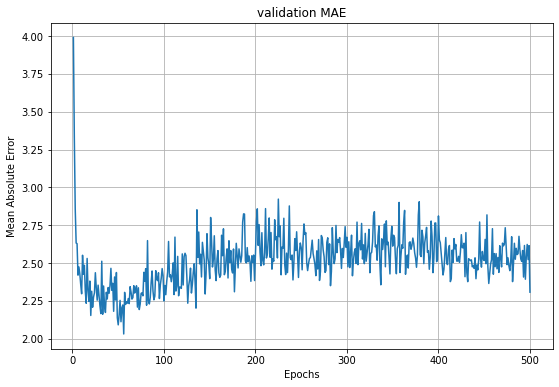

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_boston.history['val_mae'])+1)
plt.figure(figsize = (9,6))
plt.plot(epochs, Hist_boston.history['val_mae'])
plt.title('validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

- 5번째 이후 MAE 확인

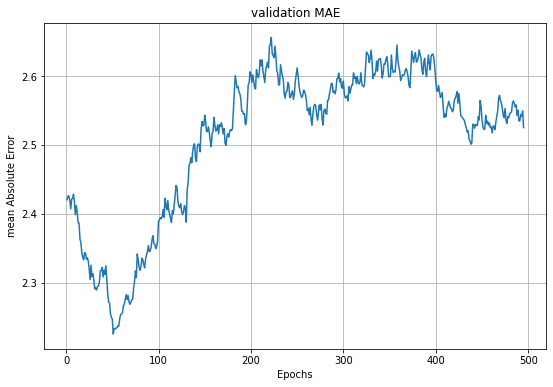

In [22]:
def smooth_curve(points, factor = 0.9) :
    smoothed_points = []
    for point in points :
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point * (1-factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

mae_history = Hist_boston.history['val_mae']
mae_history = smooth_curve(mae_history[5:])

plt.figure(figsize = (9,6))
plt.plot(range(1, len(mae_history)+1), mae_history)
plt.title('validation MAE')
plt.xlabel('Epochs')
plt.ylabel('mean Absolute Error')
plt.grid()
plt.show()

## 6) Keras Session Clear

In [24]:
from tensorflow.keras import backend as K

K.clear_session()

# 4. Early Stopping

## 1) Model Define & Compile

In [25]:
boston = models.Sequential(name = 'EarlyStopping')
boston.add(layers.Dense(64, activation = 'relu', input_shape = (13,)))
boston.add(layers.Dense(64, activation = 'relu'))
boston.add(layers.Dense(1))

boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

## 2) EarlyStopping()

- monitor : 모키터링 대상 성능
- mode : 모니터링 대상을 최소화(min) 또는 최대화(max)
- patience : 성능이 개선되지 않는 epoch 횟수

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_mae',
                   mode = 'min',
                   patience = 50,
                   verbose = 1)

## 3) ModelCheckpoint()

- 'best_boston.h5' : 최적 모델이 저장될 경로
- save_best_only : 최적모델만 저장할지 지정

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_boston.h5',
                     monitor = 'val_mae',
                     mode = 'min',
                     save_best_only = True,
                     verbose = 1)

## 4) Model Fit with callbacks

- callbacks : Earlystopping()과 ModelCheckpoint() 객체 지정

In [29]:
%%time

Hist_boston = boston.fit(X_train, y_train,
                         epochs = 500,
                         batch_size = 1,
                         validation_data = (X_valid, y_valid),
                         callbacks = [es, mc],
                         verbose =1)

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 218.7759 - mae: 11.2194 - val_loss: 48.4262 - val_mae: 4.1472

Epoch 00001: val_mae improved from inf to 4.14717, saving model to best_boston.h5
Epoch 2/500
323/323 [==============================] - 1s 2ms/step - loss: 30.0880 - mae: 3.8477 - val_loss: 34.2644 - val_mae: 3.2694

Epoch 00002: val_mae improved from 4.14717 to 3.26944, saving model to best_boston.h5
Epoch 3/500
323/323 [==============================] - 1s 2ms/step - loss: 21.7808 - mae: 3.2315 - val_loss: 29.5469 - val_mae: 3.0711

Epoch 00003: val_mae improved from 3.26944 to 3.07111, saving model to best_boston.h5
Epoch 4/500
323/323 [==============================] - 1s 2ms/step - loss: 18.7751 - mae: 2.9823 - val_loss: 26.4849 - val_mae: 2.8473

Epoch 00004: val_mae improved from 3.07111 to 2.84730, saving model to best_boston.h5
Epoch 5/500
323/323 [==============================] - 1s 2ms/step - loss: 15.8261 - mae: 2.7299 - val_loss: 23.36

## 5) Best Model

In [30]:
!ls -l

total 76
-rw-r--r-- 1 root root 70280 Sep 30 02:43 best_boston.h5
drwxr-xr-x 1 root root  4096 Sep 16 13:40 sample_data


## 6) Model Evaluate

In [31]:
from tensorflow.keras.models import load_model

best_boston = load_model('best_boston.h5')
test_mse_score, test_mae_score = best_boston.evaluate(X_test, y_test)
print("MAE = ", test_mae_score)

4/4 [==============================] - 0s 4ms/step - loss: 17.7513 - mae: 2.4879
MAE =  2.4879050254821777


# THE END